First we implment the images processing.

1. Load data from folders
3. Resize images to 128x128 and flatten to gray scale
4. vectorize the images
5. one hot vector labels
2. normalize data 0.0 - 1.0 range
6. cross validation split

Example of how each image is processed. We have a grayscale image resized to 128x128

In [1]:
from time import time
import sys
sys.path.append('/models/StateFarmChallenge')
import os
import glob
from multiprocessing.pool import Pool
from contextlib import closing
import logging

from six.moves import xrange
import tensorflow as tf
import matplotlib.pyplot as plt
import Image
import numpy as np

from submission import Submission

import math
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

logging.basicConfig(filename='training.log', level=logging.info)

(256, 192)
(192, 256)
[[ 0.09019608  0.07450981  0.08627451 ...,  0.94901961  0.91764706
   0.80000001]
 [ 0.09019608  0.07450981  0.07058824 ...,  0.93725491  0.95686275
   0.96862745]
 [ 0.08627451  0.08627451  0.07843138 ...,  0.89411765  0.9254902
   0.93725491]
 ..., 
 [ 0.11764706  0.10588235  0.10980392 ...,  0.03529412  0.03137255
   0.02745098]
 [ 0.10196079  0.09411765  0.09019608 ...,  0.03529412  0.03137255
   0.02745098]
 [ 0.07843138  0.08235294  0.07058824 ...,  0.03529412  0.03137255
   0.02745098]]


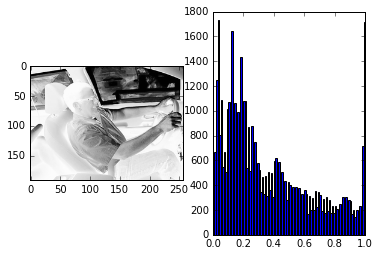

In [39]:
%matplotlib inline

_, (ax1, ax2) = plt.subplots(1, 2)

# Load and resize test image
img = Image.open('/data/imgs/train/c0/img_11035.jpg').convert('L')
img.thumbnail((256,256), Image.ANTIALIAS)
print(img.size)

# Create numpy array from image and normalize data
data = np.array(img.getdata()).astype(np.float32)
data_std = (data - min(data)) / (max(data) - min(data))

img_form = data_std.reshape(192,256)
print(img_form.shape)
print(img_form)

# Show Image and distribution of data for sanity check
ax1.imshow(img_form, cmap=plt.cm.Greys);
ax2.hist(img_form.ravel(), bins=100, range=(0,1));

The sanity check looks good!

Now lets test our images processor that we implmented and confirm it matches what we expect.

In [40]:
DATA_PATH = '/data/imgs/train'


def process_image(img_file):
    """
    Resize image to 128x128, flatten color and normalize
    """
    # Load and resize test image
    img = Image.open(img_file).convert('L')
    img.thumbnail((128,128), Image.ANTIALIAS)

    # Create numpy array from image and normalize data
    data = np.array(img.getdata()).astype(np.float32)
    data_std = (data - min(data)) / (max(data) - min(data))

    return data_std

# Create one hot vector
def vectorize_label(label):
    one_hot = np.zeros(10).astype(np.float32)
    one_hot[label] = 1.0
    return one_hot


def process_folder((label, folder)):
    img_paths = os.path.join(DATA_PATH, folder, '*.jpg')
    img_files = glob.glob(img_paths)
    print('Processing folder: {} {} items'.format(folder, len(img_files)))
    
    imgs = []
    labels = []
    
    for j in range(len(img_files)):
        if j % 500 is 0 and j is not 0:
            ratio = float(j) / float(len(img_files))
            print('Processed {:.0%} of folder {}'.format(ratio, folder)) 
    

        processed_image = process_image(img_files[j])
        imgs.append(processed_image)
        labels.append(label)
        
    return imgs, labels


def process_testing(files):
    img_paths = os.path.join('/data/imgs/', 'test', '*.jpg')
    img_files = glob.glob(img_paths)
    print('Processing testing data... {} images'.format(amount))
    
    imgs = []
    
    for i in range(amount):
        if i % 500 is 0 and i is not 0:
            ratio = float(i) / float(amount)
            print('Processed {:.0%} of data'.format(ratio))
            
        processed_img = process_image(img_files[i])
        imgs.append(processed_img)
        
    return imgs

In [44]:
# Folders to process
folders = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

ts = time()
# Create a pool that can run parallel processes
# My system has 6 CPU's, lets use all of them
with closing(Pool(6)) as p:
    folder_label_map = list(enumerate(folders))
    data = p.map(process_folder, folder_label_map)
    p.terminate()
    
print('Took {}s'.format(time() - ts))

Processing folder: c5 2312 items
Processing folder: c4 2326 items
Processing folder: c2 2317 items
Processing folder: c0 2489 items
Processing folder: c1 2267 items
Processing folder: c3 2346 items
Processed 21% of folder c4
Processed 21% of folder c3
Processed 22% of folder c1
Processed 22% of folder c2
Processed 22% of folder c5
Processed 20% of folder c0
Processed 43% of folder c4
Processed 44% of folder c1
Processed 43% of folder c5
Processed 43% of folder c3
Processed 43% of folder c2
Processed 40% of folder c0
Processed 64% of folder c4
Processed 65% of folder c5
Processed 64% of folder c3
Processed 66% of folder c1
Processed 65% of folder c2
Processed 60% of folder c0
Processed 86% of folder c4
Processed 85% of folder c3
Processed 87% of folder c5
Processed 86% of folder c2
Processed 88% of folder c1
Processed 80% of folder c0
Processing folder: c6 2325 items
Processing folder: c7 2002 items
Processing folder: c8 1911 items
Processing folder: c9 2129 items
Processed 26% of folde

Process the testing folder so I can run validation againsts it as well.

In [5]:
img_paths = os.path.join('/data/SFC/imgs', 'test', '*.jpg')
img_files = glob.glob(img_paths)
print('Processing testing data... {} images'.format(len(img_files)))

Processing testing data... 79726 images


In [261]:
print(img_files[:3])

['/data/imgs/test/img_65245.jpg', '/data/imgs/test/img_21828.jpg', '/data/imgs/test/img_35506.jpg']


Here we process some testing data for classification.

In [358]:
test_images = process_testing(2000)

Processing testing data... 2000 images
Processed 25% of data
Processed 50% of data
Processed 75% of data


In [33]:
print(test_images[0])

NameError: name 'test_images' is not defined

Now we need to put the data into a proper shape, the map function sort of mangles that data by creating a deminsion for each folder which contains every image and label for the folder, howevrer we want one big list of image vectors and labels not 10 seperate lists.

In [45]:
images = []
labels = []
for i, f in enumerate(data):
    for k in range(2):
        for j in data[i][k]:
            if k is 0:
                images.append(j)
            else:
                labels.append(j)


In [51]:
print(images[0].shape)
print(labels[0])
print(len(images))
print(labels[:10])

(12288,)
0
22424
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


looks good lets reshape the vector and put it into an visual

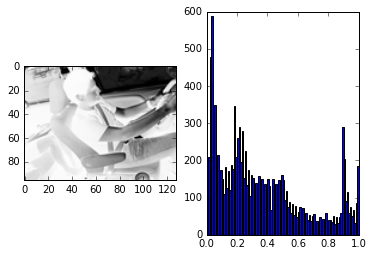

In [52]:
_, (ax, ax2) = plt.subplots(1, 2)
ax.imshow(images[1000].reshape(96,128), cmap=plt.cm.Greys);
ax2.hist(images[1000].ravel(), bins=100, range=(0,1));

Every thing seems to have worked as expected! We have a proper shape, image and label.

Lets picle up our processed data so that we don't have to re-process it later.

In [6]:
import cPickle as pickle

In [8]:
with open('/data/SFC/images.pkl', 'wb') as f:
    pickle.dump(images, f)
    
with open('/data/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

NameError: name 'images' is not defined

In [9]:
with open('/data/SFC/images.pkl', 'rb') as f:
    images = pickle.load(f)

print(len(images))

EOFError: 

In [8]:
with open('/data/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

print(len(labels))

22424


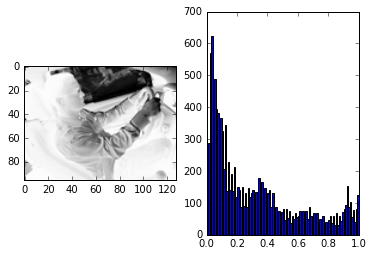

In [133]:
_, (ax, ax2) = plt.subplots(1, 2)
ax.imshow(images[10].reshape(96,128), cmap=plt.cm.Greys);
ax2.hist(images[10].ravel(), bins=100, range=(0,1));

In [45]:
from sklearn import cross_validation

features_train, features_validation, labels_train, labels_validation = \
cross_validation.train_test_split(images, labels, test_size=.05)


num_examples = len(features_train)

print(num_examples)
print(len(features_validation))

21302
1122


In [24]:
def shuffle_data(X, y):
    perm = np.random.permutation(len(X))
    X = [X[i] for i in perm]
    y = [y[j] for j in perm]
    return X, y

Now our data is set up, we have all our training data processed and loaded, we also have our data cross validated with 10% set aside to do validation

Here we use the template provided by Google to set up the inference, loss, training design pattern.

In [4]:
"""
Implements the inference/loss/training pattern for model building.
1. inference() - Builds the model as far as is required for running the network
forward to make predictions.
2. loss() - Adds to the inference model the layers required to generate loss.
3. training() - Adds to the loss model the Ops required to generate and
apply gradients.
This file is used by the various "feed.py" files and not meant to
be run.
"""

#Number of output classes
NUM_CLASSES = 10

#Size the input images
IMAGE_PIXELS = 128 * 96


def inference(images, hidden1_units, hidden2_units, hidden3_units):
    """
    Args:
    images: Images placeholder, from inputs().
    hidden1_units: Size of the first hidden layer.
    hidden2_units: Size of the second hidden layer.
    hidden3_units: Sive of the third hidden layer.
    Returns:
    softmax_linear: Output tensor with the computed logits.
    """

    # Hidden 1
    with tf.name_scope('hidden1'):
        # Init our weights with some random data
        weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
            stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))), name='weights_1')

        biases = tf.Variable(tf.zeros([hidden1_units]), name='biases_1')
        z = tf.matmul(images, weights) + biases
        hidden1 = tf.nn.relu(z)

    # Hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev=1.0 / math.sqrt(float(hidden1_units))), name='weights_2')

        biases = tf.Variable(tf.zeros([hidden2_units]),name='biases_2')
        z = tf.matmul(hidden1, weights) + biases
        hidden2 = tf.nn.relu(z)
        
    # Hidden 3
    with tf.name_scope('hidden3'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, hidden3_units],
                                stddev=1.0 / math.sqrt(float(hidden2_units))), name='weights_3')

        biases = tf.Variable(tf.zeros([hidden3_units]),name='biases_3')
        z = tf.matmul(hidden2, weights) + biases
        hidden3 = tf.nn.relu(z)


    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden3_units, NUM_CLASSES],
                                stddev=1.0 / math.sqrt(float(hidden3_units))), name='weights_s')

        biases = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_s')
        logits = tf.matmul(hidden3, weights) + biases
        
    return logits


def loss(logits, labels):
    """"
    Calculates the loss from the logits and the labels.
    Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int64 - [batch_size].
    Returns:
    loss: Loss tensor of type float.
    """
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return loss


def training(loss, learning_rate):
    """
    Sets up the training Ops.
    Creates a summarizer to track the loss over time in TensorBoard.
    Creates an optimizer and applies the gradients to all trainable variables.
    The Op returned by this function is what must be passed to the
    `sess.run()` call to cause the model to train.
    Args:
    loss: Loss tensor, from loss().
    learning_rate: The learning rate to use for gradient descent.
    Returns:
    train_op: The Op for training.
    """
    # Add a scalar summary for the snapshot loss. (Tensor board)
    tf.scalar_summary('loss', loss)

    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # decay on our learning rate as we progress with training
#     learn_rate = tf.train.exponential_decay(learning_rate, global_step, 5000, 0.8)
    tf.scalar_summary('learn_rate', learning_rate)
    
    # Create the gradient Adam optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    return train_op


def evaluation(logits, labels):
    """Evaluate the quality of the logits at predicting the label.
    Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).
    Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
    """
    # For a classifier model, we can use the in_top_k Op.
    # It returns a bool tensor with shape [batch_size] that is true for
    # the examples where the label is in the top k (here k=1)
    # of all logits for that example.
    correct = tf.nn.in_top_k(logits, labels, 1)
    # Return the number of true entries.
    return tf.reduce_sum(tf.cast(correct, tf.int32))


print('done')

done


Now we set up the feed to feed the model data for training. Here we create the helper functions for placeholders, eval and setting up the dictionary of data.

In [5]:
# Basic model parameters
learning_rate = .01
max_steps = 1000
hidden1 = 512
hidden2 = 512
hidden3 = 512
batch_size = 100
train_dir = '/data/'
model_save = '/models/sfc/checkpoints'
summary_dir = '/models/sfc/summary'


In [39]:
num_examples = len(features_train)

In [6]:
def placeholder_inputs(batch_size):
    """Generate placeholder variables to represent the input tensors.
    These placeholders are used as inputs by the rest of the model building
    code and will be fed from the downloaded data in the .run() loop, below.
    Args:
    batch_size: The batch size will be baked into both placeholders.
    Returns:
    images_placeholder: Images placeholder.
    labels_placeholder: Labels placeholder.
    """
    # Note that the shapes of the placeholders match the shapes of the full
    # image and label tensors, except the first dimension is now batch_size
    # rather than the full size of the train or test data sets.

    images_placeholder = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_PIXELS), name='img_pl')
    labels_placeholder = tf.placeholder(tf.int64, shape=(batch_size), name='lb_pl')

    return images_placeholder, labels_placeholder


def fill_feed_dict(k, features, labels, images_pl, labels_pl):
    """
    Fills the feed_dict for training the given step.
    A feed_dict takes the form of:
    feed_dict = {
      <placeholder>: <tensor of values to be passed for placeholder>,
      ....
    }
    Args:
    data_set: The set of images and labels
    images_pl: The images placeholder, from placeholder_inputs().
    labels_pl: The labels placeholder, from placeholder_inputs().
    Returns:
    feed_dict: The feed dictionary mapping from placeholders to values.
    """

    # Create the feed_dict for the placeholders filled with the next
    images_feed = features[k : k + batch_size]
    labels_feed = labels[k : k + batch_size]

    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
    }
    return feed_dict


def do_eval(sess, eval_correct, images_placeholder, labels_placeholder, features_test, labels_test):
    """
    Runs one evaluation against the full epoch of data.
    Args:
    sess: The session in which the model has been trained.
    eval_correct: The Tensor that returns the number of correct predictions.
    images_placeholder: The images placeholder.
    labels_placeholder: The labels placeholder.
    data_set: The set of images and labels to evaluate, from
      input_data.read_data_sets().
    """

    # And run one epoch of eval.
    true_count = 0  # Counts the number of correct predictions.
    steps_per_epoch = len(features_test) // batch_size
    num_examples = steps_per_epoch * batch_size

    for step in xrange(steps_per_epoch):
        k = step * batch_size
        feed_dict = fill_feed_dict(k, features_test, labels_test, images_placeholder, labels_placeholder)
        true_count += sess.run(eval_correct, feed_dict=feed_dict)


    precision = true_count / num_examples
    print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' % (num_examples, true_count, precision))
    logging.info('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' % (num_examples, true_count, precision))


Now we set up our graph and variables .

In [7]:
# Reset graph since notebooks and jumble the variables
tf.reset_default_graph()

# Generate placeholders for the images and labels.
images_placeholder, labels_placeholder = placeholder_inputs(batch_size)

# Build a Graph that computes predictions from the inference model.
logits = inference(images_placeholder, hidden1, hidden2, hidden3)

# Add to the Graph the Ops for loss calculation.
ls = loss(logits, labels_placeholder)

# Add to the Graph the Ops that calculate and apply gradients.
train_op = training(ls, learning_rate)

# Add the Op to compare the logits to the labels during evaluation.
eval_correct = evaluation(logits, labels_placeholder)

# Build the summary operation based on the TF collection of Summaries.
summary_op = tf.merge_all_summaries()

# Create a saver for writing training checkpoints.
saver = tf.train.Saver()

print('Done')

Done


Create the session an make it interactive so we can go back and play with hyperparameters.

In [8]:
# Create a session for running Ops on the Graph.
sess = tf.Session()
sess.as_default()

# Run the Op to initialize the variables.
init = tf.initialize_all_variables()
sess.run(init)

# Instantiate a SummaryWriter to output summaries and the Graph.
summary_writer = tf.train.SummaryWriter(summary_dir, sess.graph)


print('Done')

Done


In [9]:
# Restore our saved model
saver.restore(sess, model_save)
print('Restored')

Restored


In [43]:
sess.close()

Training block

In [58]:
# And then after everything is built, start the training loop.
train_begin = time.time()
for step in xrange(max_steps):
    start_time = time.time()

    steps_per_epoch = len(features_train) // batch_size
    k = (step % steps_per_epoch) * batch_size
    
    #   Fill a feed dictionary with the actual set of images and labels
    #   for this particular training step.
    feed_dict = fill_feed_dict(k, features_train, labels_train, images_placeholder, labels_placeholder)

    #   Run one step of the model.  The return values are the activations
    #   from the `train_op` (which is discarded) and the `loss` Op.  To
    #   inspect the values of your Ops or variables, you may include them
    #   in the list passed to sess.run() and the value tensors will be
    #    returned in the tuple from the call.
    _, loss_value, preds = sess.run([train_op, ls, logits], feed_dict=feed_dict)

    duration = time.time() - start_time

    # Write the summaries and print an overview fairly often.
    if step % 100 == 0:
        # Print status to stdout.
        print('Step %d: loss = %.3f (%.3f sec)' % (step, loss_value, duration))
        logging.info('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
        
        # Update the events file.
        summary_str = sess.run(summary_op, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()

    # Save a checkpoint and evaluate the model periodically.
    if (step + 1) % 1000 == 0 or (step + 1) == max_steps:
        save_path = saver.save(sess, model_save + '/checkpoint_' + str(step) + '.ckpt'))
        print('Session Saved at {}'.format(save_path))
        logging.info('Session Saved at {}'.format(save_path))
        

        # Evaluate against the training set.
        print('Training Data Eval:')
        logging.info('Training Data Eval:')
        do_eval(sess, eval_correct, images_placeholder, labels_placeholder, 
                features_train, labels_train)

        # Evaluate against the validation set.
        print('Validation Data Eval:')
        logging.info('Validation Data Eval:')
        do_eval(sess, eval_correct, images_placeholder, labels_placeholder,
                features_validation, labels_validation)
        
        features_train, labels_train = shuffle_data(features_train, labels_train)

print('{:.3}m'.format((time.time() - train_begin) / 60))

Step 0: loss = 0.01 (0.280 sec)
Step 100: loss = 0.05 (0.297 sec)
Step 200: loss = 0.01 (0.292 sec)
Step 300: loss = 0.01 (0.282 sec)
Step 400: loss = 0.00 (0.282 sec)
Step 500: loss = 0.01 (0.293 sec)
Step 600: loss = 0.01 (0.290 sec)
Step 700: loss = 0.01 (0.285 sec)
Step 800: loss = 0.01 (0.280 sec)
Step 900: loss = 0.01 (0.283 sec)
Session Saved at /models/sfc/sfc.ckpt
Training Data Eval:
  Num examples: 21300  Num correct: 21296  Precision @ 1: 0.9998
Validation Data Eval:
  Num examples: 1100  Num correct: 1088  Precision @ 1: 0.9891
5.64m


Let's see what we get.

In [59]:
print(preds[1])
# Run a softmax on our nn output to generate the probability distribution for our batch, which is used for logloss
p = sess.run(tf.nn.softmax(logits), feed_dict=feed_dict)
print(p[1])
print(feed_dict[labels_placeholder][1])

[ -0.02746136   0.49195001  -1.58244741  11.57002735   1.54469132
  -1.89813399  -4.91930676  -5.86126184  -0.26916426   2.31528711]
[  9.20736875e-06   1.68909410e-05   1.94914332e-06   9.99846697e-01
   4.05616011e-05   1.32700791e-06   6.71855958e-08   2.57893671e-08
   7.92476021e-06   7.54043213e-05]
3


Looks promising, lets run the Log loss function from kaggle.

In [60]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

Lets calculate the log loss for one of our batches.

In [61]:
labels_batch = [vectorize_label(x) for x in feed_dict[labels_placeholder]]
sum(logloss(labels_batch, p))

0.005356283945729956

Evaluation for the entire training set to be sure before we run the entire test set.

In [201]:
do_eval(sess, eval_correct, images_placeholder, labels_placeholder, images, labels)

  Num examples: 22400  Num correct: 22233  Precision @ 1: 0.9925


In [10]:
def process_test_image(img_file):
    # Load and resize test image
    img = Image.open(img_file).convert('L')
    img.thumbnail((128,128), Image.ANTIALIAS)

    # Create numpy array from image and normalize data
    data = np.array(img.getdata()).astype(np.float32)
    
    try:
        data_std = (data - min(data, axis=0)) / (max(data, axis=0) - min(data, axis=0))
    except:
        data_std = data / 255.0
        
    file_name = img_file.split('/')[4]
    
    return data_std, file_name

In [42]:
fn = [batches[11][i].split('/')[4] for i in range(len(batches[11]))]
print(fn[-46:])
print(len(fn[-46:]))
print(img_files[0])

['img_10022.jpg', 'img_83833.jpg', 'img_70582.jpg', 'img_101385.jpg', 'img_63529.jpg', 'img_33844.jpg', 'img_45403.jpg', 'img_88268.jpg', 'img_41019.jpg', 'img_72249.jpg', 'img_11131.jpg', 'img_33753.jpg', 'img_27383.jpg', 'img_87450.jpg', 'img_83333.jpg', 'img_53100.jpg', 'img_23360.jpg', 'img_48584.jpg', 'img_66275.jpg', 'img_70086.jpg', 'img_93158.jpg', 'img_69492.jpg', 'img_93063.jpg', 'img_45392.jpg', 'img_26162.jpg', 'img_11256.jpg', 'img_81195.jpg', 'img_102089.jpg', 'img_463.jpg', 'img_21259.jpg', 'img_29935.jpg', 'img_79208.jpg', 'img_60375.jpg', 'img_74696.jpg', 'img_42676.jpg', 'img_70979.jpg', 'img_45401.jpg', 'img_81890.jpg', 'img_92473.jpg', 'img_77135.jpg', 'img_87542.jpg', 'img_70.jpg', 'img_44678.jpg', 'img_80649.jpg', 'img_65476.jpg', 'img_99303.jpg']
46
/data/imgs/test/img_65245.jpg


In [14]:
ts = time.time()

with closing(Pool(6)) as p:
    data = p.map(process_test_image, img_files)
    p.terminate()
    
print('Data processed')

test_imgs, filenames = zip(*data)
print('Data unziped : {}'.format((time.time()) - ts) / 60)

Data processed
Data unziped : -562.523403883


In [15]:
with open('/data/test_data.pkl', 'wb') as f:
    pickle.dump(data, f)
print('Done')

Done


In [13]:
with open('/data/test_data.pkl', 'rb') as f:
    data = pickle.load(f)
print('Done')

Done


In [28]:
test_imgs, filenames = zip(*data)
print('Done')

Done


In [29]:
ts = time()
itter = 5
submission = Submission('/models/submission_' + str(itter) + '.csv')
submission.generate_sub_file()

steps_per_epoch = len(test_imgs) // batch_size
for step in xrange(steps_per_epoch):
    k = step * batch_size
    feed = test_imgs[k : k + batch_size]
    feed_dict = {
        images_placeholder : feed
    }
    # find prediction distribution with the soft max function
    preds = sess.run(tf.nn.softmax(logits), feed_dict=feed_dict)

    # Write pred to file with image name
    output = zip(filenames[k : k + batch_size], preds)
    submission.append_batch(output)

    if step % 100 == 0:
        print('Done with batch {}'.format(step))

submission.done()
print((time() - ts) / 60)

Done with batch 0
Done with batch 100
Done with batch 200
Done with batch 300
Done with batch 400
Done with batch 500
Done with batch 600
Done with batch 700
3.04180794954


In [33]:
num_left = 26
last = []
for i in xrange(num_left):
    last.append(process_test_image(img_files[-i - 1]))
    
tst_imgs, file_names = zip(*last)

tst_imgs = list(tst_imgs)
file_names = list(file_names)

fake_input = np.zeros((100 - num_left, 12288))
feed = tst_imgs
for j in xrange(100 - num_left):
    feed.append(fake_input[j])
feed_dict = {
    images_placeholder : feed
}
# find prediction distribution with the soft max function
preds = sess.run(tf.nn.softmax(logits), feed_dict=feed_dict)

# Write pred to file with image name
for i in xrange(100 - num_left):
    file_names.append('nan')
    
submission = Submission('/models/submission_end_5.csv')
submission.generate_sub_file()

output = zip(file_names, preds)
submission.append_batch(output)
submission.done()
print('done')

done
